# Model 001
## Simple classification with deep LSTM network

* 5 min data
* Trained on 1 month of data
* Test for 1 week
    * The idea is to retrain every [1 week]?
* For right now, use a simple classification model to test whether the price $X_{t+1}$ is going to be higher, equal, or less than $X_t$
    * Ultimately, this needs to be improved so that the model considers whether the new price will exceed the spread, but that will be used in a future model
    
    
#### Some ideas for future models
* incorporate more variations on the resampling
    * for example, look at the max and min bid/ask prices over each interval to assess worst case and best case scenarios

## Step 1 -- import necessary libraries

In [122]:
from math import sin
from math import pi
from math import exp
from random import random
from random import randint
from random import uniform
from numpy import array
%matplotlib inline
from matplotlib import pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Bidirectional
from tensorflow.keras.layers import TimeDistributed
import pandas as pd
import seaborn as sns

# 2 - Import the data from csv file

The data is saved as a csv file.  Source data file is a parameter specified below, which allows it to be defined as required (and used with papermill, if desired)

This code expects that the datafile have 3 fields - datetime, bid, ask.  The format of the datetime is specific:
YYYY MM DD HH MI SE US
where:
* YYYY: year
* MM: padded month
* DD: padded day of month
* HH: padded 24h hour of day
* MI: padded minutes
* SE: padded seconds 
* US: padded microseconds


## 2.1 Specify the path of the source data

In [2]:
src = '/var/local/foresight/timeseries/EURGBP-2016-01.pp1'

## 2.2 Import the data

1. Load the data into a dataframe
2. Specify the column names
3. Convert the date field into the correct datetime64 object

In [46]:
data_raw = pd.read_csv(src)
data_raw.columns = ['date', 'bid', 'ask']
data_raw['date'] = pd.to_datetime(data_raw['date'], format="%Y %m %d %H %M %S %f")
data_raw.set_index('date', inplace=True)

### 2.2.1 Add new field with calculated spread

In [47]:
data_raw['spread'] = data_raw['ask' ] - data_raw['bid']

In [48]:
print(data_raw[:10])

                                bid      ask   spread
date                                                 
2016-01-04 00:00:01.000353  0.73643  0.73651  0.00008
2016-01-04 00:00:01.000471  0.73641  0.73651  0.00010
2016-01-04 00:00:01.000648  0.73641  0.73652  0.00011
2016-01-04 00:00:01.000775  0.73641  0.73651  0.00010
2016-01-04 00:00:02.000429  0.73641  0.73652  0.00011
2016-01-04 00:00:02.000993  0.73643  0.73652  0.00009
2016-01-04 00:00:02.000995  0.73643  0.73651  0.00008
2016-01-04 00:00:02.000997  0.73641  0.73651  0.00010
2016-01-04 00:00:03.000198  0.73641  0.73649  0.00008
2016-01-04 00:00:04.000740  0.73641  0.73654  0.00013


### 2.2.2 Remove duplicate indices

In [51]:
df1 = data_raw[~data_raw.index.duplicated()]
print(df1.head(10))

                                bid      ask   spread
date                                                 
2016-01-04 00:00:01.000353  0.73643  0.73651  0.00008
2016-01-04 00:00:01.000471  0.73641  0.73651  0.00010
2016-01-04 00:00:01.000648  0.73641  0.73652  0.00011
2016-01-04 00:00:01.000775  0.73641  0.73651  0.00010
2016-01-04 00:00:02.000429  0.73641  0.73652  0.00011
2016-01-04 00:00:02.000993  0.73643  0.73652  0.00009
2016-01-04 00:00:02.000995  0.73643  0.73651  0.00008
2016-01-04 00:00:02.000997  0.73641  0.73651  0.00010
2016-01-04 00:00:03.000198  0.73641  0.73649  0.00008
2016-01-04 00:00:04.000740  0.73641  0.73654  0.00013


## 2.3 Resample the data into 5 minute intervals

Create multiple versions of the data:
* forward fill
* ~~backward fill~~
* ~~interpolate~~
* nearest

In [87]:
df2a = df1.resample('5T').bfill()
df2d = df1.resample('5T').nearest()

### 2.3.1 Extract the largest spreads during each period

In [89]:
max_spreads = df1.resample('5T').max()['spread']
print(max_spreads.head(10))

date
2016-01-04 00:00:00    0.00013
2016-01-04 00:05:00    0.00012
2016-01-04 00:10:00    0.00013
2016-01-04 00:15:00    0.00013
2016-01-04 00:20:00    0.00013
2016-01-04 00:25:00    0.00013
2016-01-04 00:30:00    0.00015
2016-01-04 00:35:00    0.00012
2016-01-04 00:40:00    0.00011
2016-01-04 00:45:00    0.00011
Freq: 5T, Name: spread, dtype: float64


## 2.4 Difference the data 
Get absolute differences of the data.  Drop the first datum since this will necessarily be NaN

In [80]:
ddf2a = df2a.diff()[1:]
#ddf2b = df2b.diff()[1:]
#ddf2c = df2c.diff()[1:]
ddf2d = df2d.diff()[1:]

This will produce output similar to:

In [81]:
print(ddf2a.head(3))
#print(ddf2b.head(3))
#print(ddf2c.head(3))
print(ddf2d.head(3))

                         bid      ask   spread
date                                          
2016-01-04 00:05:00  0.00010  0.00006 -0.00004
2016-01-04 00:10:00 -0.00002  0.00002  0.00004
2016-01-04 00:15:00 -0.00003 -0.00005 -0.00002
                         bid      ask   spread
date                                          
2016-01-04 00:05:00  0.00010  0.00006 -0.00004
2016-01-04 00:10:00 -0.00002  0.00000  0.00002
2016-01-04 00:15:00 -0.00003 -0.00003  0.00000


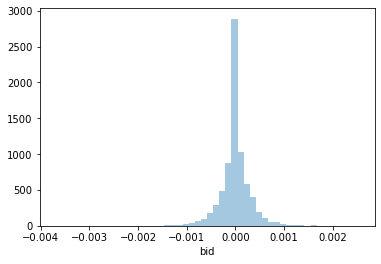

In [124]:
#sns.distplot(ddf2a['bid'], kde=False, rug=False)
sns.distplot(ddf2d['bid'], kde=False, rug=False);


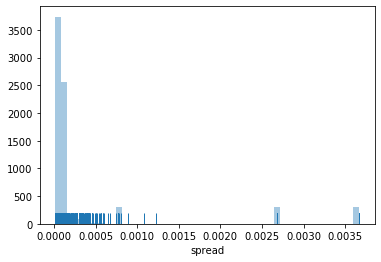

In [119]:
sns.distplot(ddf2d['spread'], kde=False, rug=True)

### 2.4.1 Replace the spreads in the differenced data with corresponding maximum spreads during the period

Shift the spreads down by 1 

In [93]:
ddf2a1 = ddf2a
ddf2a1['spread'] = max_spreads#.shift()
print(ddf2a1.head(10))

                         bid      ask   spread
date                                          
2016-01-04 00:05:00  0.00010  0.00006  0.00012
2016-01-04 00:10:00 -0.00002  0.00002  0.00013
2016-01-04 00:15:00 -0.00003 -0.00005  0.00013
2016-01-04 00:20:00 -0.00007 -0.00007  0.00013
2016-01-04 00:25:00 -0.00003 -0.00001  0.00013
2016-01-04 00:30:00 -0.00017 -0.00014  0.00015
2016-01-04 00:35:00  0.00029  0.00029  0.00012
2016-01-04 00:40:00 -0.00002 -0.00007  0.00011
2016-01-04 00:45:00 -0.00012 -0.00010  0.00011
2016-01-04 00:50:00  0.00000  0.00002  0.00011


count    5652.000000
mean        0.000142
std         0.000116
min         0.000080
0%          0.000080
5%          0.000100
10%         0.000110
15.0%       0.000110
20%         0.000110
25%         0.000110
30.0%       0.000110
35%         0.000110
40%         0.000120
45%         0.000120
50%         0.000120
55.0%       0.000130
60.0%       0.000130
65%         0.000130
70%         0.000130
75%         0.000130
80%         0.000140
85.0%       0.000150
90%         0.000160
95%         0.000230
max         0.003770
Name: spread, dtype: float64

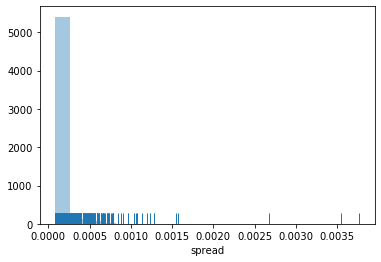

In [116]:
#print(max_spreads.hist(bins=20))
sns.distplot(max_spreads, bins=20, kde=False, rug=True)
max_spreads.describe([.05 * x for x in range(20)])

In [100]:
gains = ddf2a1[abs(ddf2a1['bid']) > ddf2a1['spread']]
print(gains.shape[0], ' out of ', ddf2a1.shape[0], ' equalling ', gains.shape[0]/ddf2a1.shape[0]/.01, '%')

3373  out of  7451  equalling  45.2690913971279 %
